# Example on the usage of Scalarizer and ScalarSolver

This notebook will go through a simple example on how to scalarize a vector valued funciton and solve it using a minimizer.

Suppose we are tasked with baking a birthday cake for our friend. We will be modelling the cake as a cylinder with a height $h$ and radius $r$, both in centimeters.
Therefore, the cake will have a volume of

$$V(r, h) = \pi r^2 \times h$$

and a surface area queal to

$$A(r, h) = 2\pi r^2 + \pi r h.$$

Just to keep the cake realistical, let us limit the radius to be greater than 2.5cm and less than 15cm, that is $2.5 < r < 15$. The
height should not exceed 50cm and be no less than 10cm: $10 < h < 50$.

We are baking the cake for a very particular friend who just fancies cake crust, and he does not really care for the filling. This implies that we would
like to bake a cake which has a surface are $A$ as large as possible while having a volume $V$ as small as possible. In other words, we wish
to maximize the surface area of the cake and minimize the volume.

Unfortunately our friend is also very picky about ratios and he has requested that the ratio of the radius and height of the cake should
not exceed the golden ratio 1.618.

This can be formualted as a multi-objective optimization problem with two objectives and two constraints. Formally

$$
\min_{r, h} \left\{
    V(r, h), -A(r, h)
    \right\} \\
    s.t.\quad \frac{r}{h} < 1.618, \\
    \quad\qquad 2.5 < r < 15, \\
    \quad\qquad 10 < h < 50.
$$

We will begin by expressing all of this in Python:

In [11]:
import numpy as np

# objectives

def volume(r, h):
    return np.pi*r**2*h

def area(r, h):
    return 2*np.pi**2 + np.pi*r*h

def objective(xs):
    # xs is a 2d array like, which has different values for r and h on its first and second columns respectively.
    xs = np.atleast_2d(xs)
    return np.stack((volume(xs[:, 0], xs[:, 1]), -area(xs[:, 0], xs[:, 1]))).T

# bounds

r_bounds = np.array([2.5, 15])
h_bounds = np.array([10, 50])
bounds = np.stack((r_bounds, h_bounds))

# constraints

def con_golden(xs):
    # constraints are defined in DESDEO in a way were a positive value indicates an agreement with a constraint, and
    # a negative one a disagreement.
    xs = np.atleast_2d(xs)
    return -(xs[:, 0] / xs[:, 1] - 1.618)

To solve this problem, we will need to scalarize it. However, before we will be able to scalarize `objective` we will need some scalarization function:

In [12]:
def simple_sum(xs):
    xs = np.atleast_2d(xs)
    return np.sum(xs, axis=1)

Now we are in a position where we can scalarize `objective` using `simple_sum`:

In [13]:
from desdeo_tools.scalarization.Scalarizer import Scalarizer

scalarized_objective = Scalarizer(objective, simple_sum)

In DESDEO, optimization will always mean minimization, at least internally. This is why we will be using a `ScalarMinimizer` to optimize
`scalaralized_objective`.

In [14]:
from desdeo_tools.solver.ScalarSolver import ScalarMinimizer
from scipy.optimize import NonlinearConstraint

# by setting the method to be none, we will actually be using the minimizer implemented
# in the SciPy library.

minimizer = ScalarMinimizer(scalarized_objective, bounds, constraint_evaluator=con_golden, method=None)

# we need to supply an initial guess
x0 = np.array([2.6, 11])
sum_res = minimizer.minimize(x0)

# the optimal solution and function value
x_optimal, f_optimal = sum_res["x"], sum_res["fun"]
objective_optimal = objective(sum_res["x"]).squeeze()

print(f"\"Optimal\" cake specs: radius: {x_optimal[0]}cm, height: {x_optimal[1]}cm.")
print(f"\"Optimal\" cake dimensions: volume: {objective_optimal[0]}, area: {-objective_optimal[1]}.")

"Optimal" cake specs: radius: 2.50000100052373cm, height: 10.000001000042642cm.
"Optimal" cake dimensions: volume: 196.34971764710062, area: 98.27906442862323.


Are we happy with this solution? No... Clearly the area of the cake could be bigger. Let us next solve for a representation of the Pareto optimal front for the defined problem. We can do this by using an achievement scalarizing function and solving the scalarized problem with a bunch of evenly generated reference points. We start by calculating the ideal and nadir points, then create a simple achievement scalarizing function, and finally generate an evenly spread set of reference points and solve the original problem by scalarizing it with the achievement scalarizing function using the generated reference points and minimizing it invidually with each reference point.

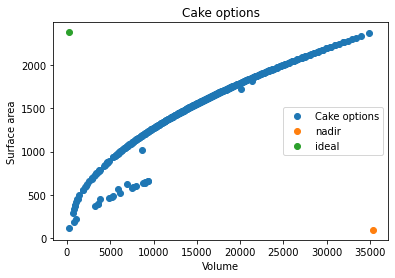

In [15]:
# define a new scalarizing function so that each of the objectives can be optimized independently
def weighted_sum(xs, ws):
    # ws stand for weights
    return np.sum(ws * xs, axis=1)


# minimize the first objective
weighted_scalarized_objective = Scalarizer(objective, weighted_sum, scalarizer_args={"ws": np.array([1, 0])})
minimizer._scalarizer = weighted_scalarized_objective
res = minimizer.minimize(x0)
first_obj_vals = objective(res["x"])

# minimize the second objective
weighted_scalarized_objective._scalarizer_args = {"ws": np.array([0, 1])}
res = minimizer.minimize(x0)
second_obj_vals = objective(res["x"])

# payoff table
po_table = np.stack((first_obj_vals, second_obj_vals)).squeeze()

ideal = np.diagonal(po_table)
nadir = np.max(po_table, axis=0)


from desdeo_tools.scalarization.ASF import PointMethodASF

# evenly spread reference points
zs = np.mgrid[ideal[0]:nadir[0]:1500, ideal[1]:nadir[1]:150].reshape(2, -1).T


asf = PointMethodASF(nadir, ideal)
asf_scalarizer = Scalarizer(objective, asf, scalarizer_args={"reference_point": None})
minimizer._scalarizer = asf_scalarizer

fs = np.zeros(zs.shape)

for i, z in enumerate(zs):
    asf_scalarizer._scalarizer_args={"reference_point": z}
    res = minimizer.minimize(x0)
    # assuming minimization is always a success
    fs[i] = objective(res["x"])


# plot the Pareto solutions in the original scale
import matplotlib.pyplot as plt

plt.title("Cake options")
plt.scatter(fs[:, 0], -fs[:, 1], label="Cake options")
plt.scatter(nadir[0], -nadir[1], label="nadir")
plt.scatter(ideal[0], -ideal[1], label="ideal")
plt.xlabel("Volume")
plt.ylabel("Surface area")
plt.legend()


Observing the Pareto optimal front, it is clear that our previous optimal objective values `objective_optimal` are just one available option. We show our friend the available options and he
decides that he wants a cake with a volume of `25000` and a surface area of `2000`. Great, now we just have to figure out the radius and height of such a cake. This should be easy:

In [16]:
# final reference point chosen by our friend
z = np.array([25000, -2000])
asf_scalarizer._scalarizer_args={"reference_point": z}
res = minimizer.minimize(x0)

final_r, final_h = res["x"][0], res["x"][1]
final_obj = objective(res["x"]).squeeze()
final_V, final_A = final_obj[0], final_obj[1]

print(f"Final cake specs: radius: {final_r}cm, height: {final_h}cm.")
print(f"Final cake dimensions: volume: {final_V}, area: {-final_A}.")
print(final_r/final_h)

Final cake specs: radius: 12.612270698952173cm, height: 49.999999cm.
Final cake dimensions: volume: 24986.558053433215, area: 2000.8700178252593.
0.2522454190239518


That is a big cake!